In [2]:
# A $2^{4-}$ Fractional Factorial Design Example
## Exercise Science Research Application
### Dr Austin R Brown
### School of Data Science and Analytics
#### Kennesaw State University

In [3]:
import os
# 1. ENTER your GitHub username (the one that owns your fork)
#github_username = "abrown9008"

# 2. Name of the repo (don't change unless your fork name is different)
#repo_name = "STAT-7220-Applied-Experimental-Design"

# 3. Build the full repo URL for cloning
#repo_url = f"https://github.com/{github_username}/{repo_name}.git"

# --- Detect if we're already in a repo ---
#cwd = os.getcwd()
#if cwd.endswith(repo_name):
#    print(f"✅ Already inside repo folder: {cwd}")
#else:
    # --- If the repo folder exists, check if it's nested ---
#    if os.path.exists(repo_name):
#        print(f"⚠️ Found existing folder '{repo_name}'. Skipping clone to avoid nesting.")
#    else:
#        print(f"📥 Cloning repo from {repo_url}...")
#        os.system(f"git clone {repo_url}")

    # --- Change to repo directory ---
#    if os.path.exists(repo_name):
#        os.chdir(repo_name)
#        print(f"📂 Changed directory to: {os.getcwd()}")
#    else:
#        print("❌ ERROR: Repo folder not found. Please check your GitHub username.")

# --- Check if this is the instructor's repo instead of student's fork ---
# This command needs to be run from within the repository directory
#remote_url = os.popen("git config --get remote.origin.url").read().strip()

#if "abrown9008" in remote_url:
#   print("⚠️ WARNING: You are working in the instructor's repo, not your fork!")
#   print("💡 Please fork the repo to your own account and update `github_username` above.")
#else:
#    print(f"🔗 Connected to fork at: {remote_url}")

# Set Today's Directory #

#today_dir = "Fractional Factorial Design"
#os.chdir(today_dir)
#print(f"📂 Changed directory to: {os.getcwd()}")

- Exercise Science Researchers are investigating how different training strategies affect muscle endurance in recreationally active adults. They are particularly interested in four binary (two-level) factors that are commonly adjusted in resistance training programs:

| Factor                    | Levels                              |
|---------------------------|--------------------------------------|
| **A. Training Frequency** | Low (2x/week) vs. High (4x/week)     |
| **B. Repetition Range**   | Low (6–8 reps) vs. High (12–15 reps) |
| **C. Rest Interval**      | Long (2 minutes) vs. Short (30 sec)  |
| **D. Exercise Order**     | Large-to-small vs. Small-to-large    |

The response variable is **muscle endurance**, measured as the number of repetitions completed at a fixed submaximal load after 6 weeks of training. They choose a one-half fractional factorial design with a **defining relation** of $I=ABCD$ (e.g., $D=ABC$.)

This means:
    - The **Exercise Order** factor (D) is aliased with the three-way interaction of A, B, and C.
    - The **Training Frequency** factor (A) is aliased with the three-way interaction of B, C, and D.
    - The **Repetition Range** factor (B) is aliased with the three-way interaction of A, C, and D.
    - The **Rest Interval** factor (C) is aliased with the three-way interaction of A, B, and D.
    - Note, what I just did in the above bullet points, where I specified what interaction effects the main effects are aliased with, is called **defining the aliasing structure** and is something you will be asked to do on a future assignment.
    - This design is of **resolution IV**, meaning that main effects are not confounded with two-way interactions, but two-way interactions may be confounded with other two-way interactions or three-way interactions.

Our data are contained in the `Muscle Endurance Example.xlsx` file. With these data, let's:

1. Build the +/- table:

To do this, we need to specify a few things. First, the number of runs is $2^{4-} = 8$. Second, we need to specify the number of factors, which is 4. Third and finally, we need to specify the defining relation, which is `I=ABCD` (i.e., $D=ABC$).

|A  |B  |C  |D  |Effect |
|:--|:--|:--|:--|:------|
|- |- |- |- |(1)    |
|+  |- |- | + |ad     |
|- |+ |- |+ |bd     |
|+ |+ |- |- |ab     |
|- |- |+ |+ |cd     |
|+ |- |+ |- |ac     |
|- |+ |+ |- |bc     |
|+ |+ |+ |+ |abcd   |

To remember which row combinations yield which effects, remember that all - are for the (1) effect. All + are for the highest-order interaction (abcd in this case). All others are mixed. For example, the ad effect is high (+) on A and D and low (-) on B and C. All other cases follow the same logic.

2. Read in the data and perform exploratory analysis.

In [ ]:
## Import Relevant Libraries ##
import pandas as pd
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan

## Load the Data ##

muscle = pd.read_excel("Muscle Endurance Example.xlsx")

## Explore the Data ##

print(muscle.head())
print(muscle.info())

## You don't need to do what I'm doing below, but with this 
## code, we're calculating all summary statistics for each factor level
## at once rather than individually. You can do it either way. ##

## Reshape the Data and Calculate Summary Statistics ##

muscle_long = (
    muscle
    .melt(
        id_vars=["MuscleEndurance"],  # variables that stay as-is
        value_vars=["TrainingFrequency", "RepetitionRange",
                    "RestInterval", "ExerciseOrder"],
        var_name="Effect",
        value_name="Level"
    )
    .groupby(["Effect", "Level"], as_index=False)
    .agg(
        mean=("MuscleEndurance", "mean"),
        sd=("MuscleEndurance", "std")
    )
)

## Map effect names to letters (handy trick for recoding) ##

effect_map = {
    "TrainingFrequency": "A",
    "RepetitionRange":   "B",
    "RestInterval":      "C",
    "ExerciseOrder":     "D"
}

muscle_long["Effect_Letter"] = muscle_long["Effect"].map(effect_map)

## Order by A, B, C, D ##

muscle_long = muscle_long.sort_values("Effect_Letter").reset_index(drop=True)

print(muscle_long)

  TrainingFrequency RepetitionRange RestInterval   ExerciseOrder  Replicate  MuscleEndurance
0               Low             Low         Long  Large-to-Small          1             36.8
1               Low             Low         Long  Large-to-Small          2             37.8
2               Low             Low         Long  Large-to-Small          3             43.2
3              High             Low         Long  Small-to-Large          1             51.7
4              High             Low         Long  Small-to-Large          2             51.9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TrainingFrequency  24 non-null     object 
 1   RepetitionRange    24 non-null     object 
 2   RestInterval       24 non-null     object 
 3   ExerciseOrder      24 non-null     object 
 4   Replicate          24 non-null     int64  
 5  

- For effect A:
    - We see a roughly $3\sigma$ difference between the High and Low levels of Training Frequency, suggesting a significant effect.
- For effect B:
    - There is a smaller difference between the High and Low levels of Repetition Range (roughly $1\sigma$), indicating a moderate effect.
- For effect C:
    - The difference between Long and Short Rest Intervals is minimal (around $0.5\sigma$), suggesting a weak effect.
- For effect D:
    - The difference between Large-to-small and Small-to-large Exercise Order is also minimal (around $0.5\sigma$), indicating a weak effect.

3. Build the ANOVA model and evaluate the assumptions.

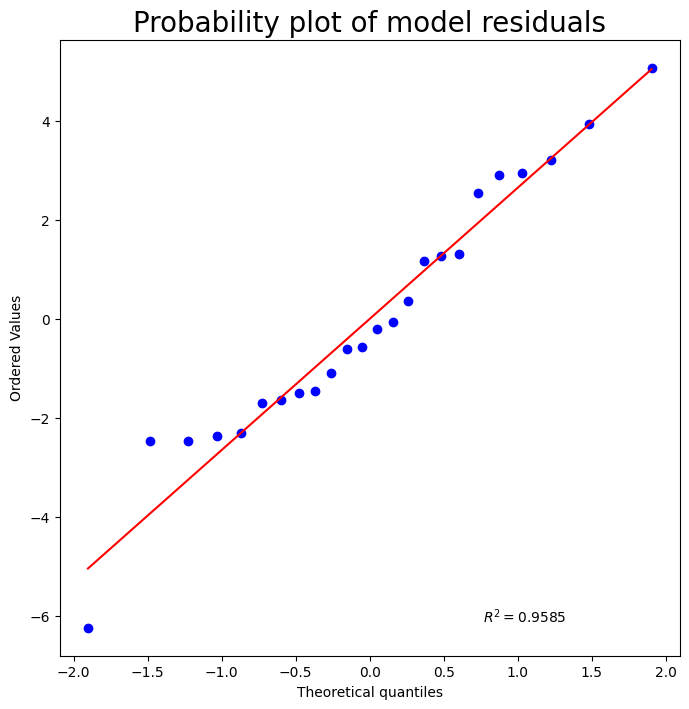

Shapiro-Wilk Test Statistic: 0.9642200106060277
p-value: 0.5288414788889192


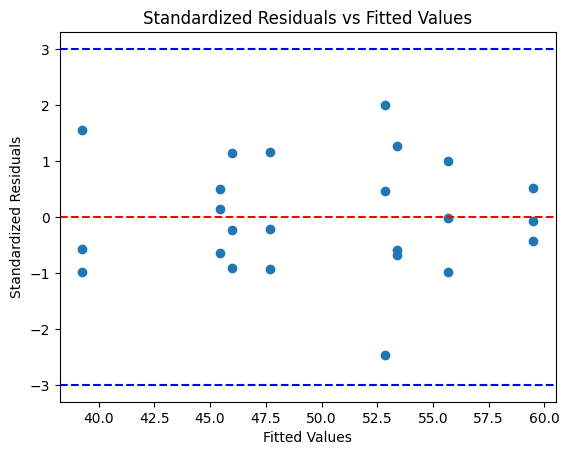

F-statistic: 2.2254603004910716
F p-value: 0.08777374975250013


In [14]:
import scipy.stats as stats

## Fit ANOVA model with interactions ##

model = ols(
    "MuscleEndurance ~ TrainingFrequency * RepetitionRange * RestInterval * ExerciseOrder",
    data=muscle).fit()

## Extract Model Residuals ##

res = model.resid

## Generate QQ-plot ##
fig = plt.figure(figsize= (8, 8))
ax = fig.add_subplot(111)
normality_plot, stat = stats.probplot(res, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set
plt.show()


## Run Shapiro-Wilk Test for Normality ##

shapiro_test = stats.shapiro(res)
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic}')
print(f'p-value: {shapiro_test.pvalue}')

## Generate Scatterplot of Standardized Residuals vs Fitted Values ##

standard_res = model.get_influence().resid_studentized_internal
fitted_vals = model.fittedvalues

plt.scatter(fitted_vals, standard_res)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='b', linestyle='--')
plt.axhline(y=-3, color='b', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals vs Fitted Values')
plt.show()

## Perform Breusch-Pagan Test for Homoscedasticity ##

bp_test = het_breuschpagan(res, model.model.exog)

## Extract F-statistic ##

f_statistic = bp_test[2]

## Extract its P-Value ##

f_p_value = bp_test[3]

print(f"F-statistic: {f_statistic}")
print(f"F p-value: {f_p_value}")

- For normality:
    - The Q-Q plot shows that the residuals closely follow the diagonal line with little deviation, indicating that the normality assumption is satisfied.
    - The p-value associated with the S-W test is greater than 0.05, further indicating that the data are supportive of the assumption of the normality of residuals.

- For constant variance:
    - The scatterplot of the fitted values vs the standardized residuals shows:
        1. No points are greater than +3 or less than -3 
        2. The residuals are randomly scattered around zero implying that zero is a good estimate of the mean of the residuals.
        3. The heights of the residuals appear to be roughly constant across the range of fitted values, indicating constant variance.
    - The B-P test statistic is associated with a p-value greater than 0.05, further indicating that the data are supportive of the assumption of constant variance.

4. Analyze the ANOVA results.

In [20]:
## Print ANOVA table ##
anova_table = sm.stats.anova_lm(model, typ=3) # Note, we're using Type 3 SS here which allows us to test in the presence of interactions & all other factors
## Add Significance Column ##
anova_table['Significance'] = np.where(anova_table['PR(>F)'] < 0.05, 'Significant', 'Not Significant')
## Filter to only main effects and two-way interactions ##

print(anova_table)

                                                         sum_sq    df           F        PR(>F)     Significance
Intercept                                           9296.333333   1.0  969.546324  9.545507e-16      Significant
TrainingFrequency                                    441.301802   1.0   46.024871  4.387956e-06      Significant
RepetitionRange                                      105.136039   1.0   10.964996  4.412575e-03      Significant
RestInterval                                           4.641486   1.0    0.484076  4.965642e-01  Not Significant
ExerciseOrder                                          1.471647   1.0    0.153483  7.003975e-01  Not Significant
TrainingFrequency:RepetitionRange                    135.095537   1.0   14.089575  1.734499e-03      Significant
TrainingFrequency:RestInterval                         3.262188   1.0    0.340225  5.678311e-01  Not Significant
RepetitionRange:RestInterval                           0.783379   1.0    0.081701  7.786726e-01 

- Here we see that:
    1. Training Frequency (A) has a significant effect on muscle endurance (p < 0.05).
    2. Repetition Range (B) has a significant effect (p < 0.05).
    3. Rest Interval (C) does not have a significant effect (p = 0.4966).
    4. Exercise Order (D) does not have a significant effect (p = 0.7004).
    5. The interaction between Training Frequency and Repetition Range (AB) is significant (p < 0.05).
    6. The interaction between Rest Interval and Exercise Order (CD) is significant (p < 0.05).

5. Let's estimate the effects and calculate the partial $\eta^2$ values.

In [21]:
# add factorial effect labels (rep each=3)
effects = ["(1)","ad","bd","ab","cd","ac","bc","abcd"]
muscle = muscle.assign(Effect=np.repeat(effects, 3))

# group and compute means
df = (
    muscle.groupby("Effect", as_index=False)["MuscleEndurance"]
    .mean()
    .rename(columns={"MuscleEndurance": "mean"})
)

# pivot wider
df_wide = df.pivot_table(index=None, columns="Effect", values="mean")

# extract columns (with special handling for `(1)`)
base = df_wide["(1)"]
ad   = df_wide["ad"]
bd   = df_wide["bd"]
ab   = df_wide["ab"]
cd   = df_wide["cd"]
ac   = df_wide["ac"]
bc   = df_wide["bc"]
abcd = df_wide["abcd"]

# compute effects
result = pd.DataFrame({
    "A": 0.25 * (-base + ad - bd + ab - cd + ac - bc + abcd),
    "B": 0.25 * (-base - ad + bd + ab - cd - ac + bc + abcd),
    "C": 0.25 * (-base - ad - bd - ab + cd + ac + bc + abcd),
    "D": 0.25 * (-base + ad + bd - ab + cd - ac - bc + abcd),
})

print(result)

              A      B      C      D
mean  10.758333  4.475  2.775  2.225


Just like in the other example, these differences are simply the mean difference between the + and - levels of each factor. These tell us, contextually, how muscle endurance is expected to change, on average, moving from the - level to the + level. We have to remember that these main effects are aliased with the three-way interactions specified previously. But, if we assume that the three-way interactions are not significant, we can safely interpret these main effects on their own without worrying about needing to perform a fold-over design.

Let's calculate partial $\eta^2$ now:

In [26]:
## Import pingouin for effect size calculations ##
import pingouin as pg

## Calculate Partial Eta Squared Effect Sizes ##

effect_sizes = pg.anova(
    dv="MuscleEndurance",
    between=["TrainingFrequency", "RepetitionRange", "RestInterval", "ExerciseOrder"],
    data=muscle,
    detailed=True
)

print(effect_sizes[['Source', 'np2']][:10])  # Display only main effects and two-way interactions

                                Source       np2
0                    TrainingFrequency  0.819059
1                      RepetitionRange  0.439211
2                         RestInterval  0.231462
3                        ExerciseOrder  0.162212
4  TrainingFrequency * RepetitionRange  0.000003
5     TrainingFrequency * RestInterval  0.048504
6       RepetitionRange * RestInterval  0.000024
7    TrainingFrequency * ExerciseOrder  0.000024
8      RepetitionRange * ExerciseOrder  0.048504
9         RestInterval * ExerciseOrder  0.000003


The partial $\eta^2$ values for the main effects are all large (> 0.14) and the two-way interactions are all small with the possible of exception of Training Frequency and Rest Interval and Repetition Range/Exercise Order approaching the medium threshold. This is consistent with what we saw in the ANOVA table. 

## Conclusion

So finally, contextually, what does this all suggest? All of the + levels of the main effects are associated with greater muscle endurance with Training Frequency and Repetition Range being most important.